In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_long_from_analysis,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
from amftrack.util.plot import gridplot
import logging
from datetime import timedelta

%store -r path_figure

logging.getLogger().setLevel(logging.WARNING)
plt.style.use('presentation.mplstyle')

%matplotlib widget

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:

plates_paper = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404",
]
plates_paper += [
    "1014_20220525",
    "1023_20220502",
    "1042_20220523",
    "1045_20220504",
    "1048_20220506",
    "1053_20220413",
    "127_20220705",
    "130_20220707",
    "800_20210928",
]

In [16]:
plates_paper = [
"877_20220419",
"56_20220701",
"52_20220707",
"99_20220815",
"105_20220817",
"108_20220823",
"111_20220823",
"106_20220826",
"938_20220325",
"839_20220325",
"941_20220404",
"991_20220325",
"1024_20220516",
"1040_20220502",
"1048_20220506",
"1014_20220525",
"1053_20220413",
"1031_20220419",
"1045_20220504",
"1035_20220518",
"12_20220502",
"13_20220422",
# "21_20220502",
"32_20220428",
"30_20220506",
"81_20220704",
"91_20220708",
"89_20220705"
]

In [17]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates_paper)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)

In [27]:
def get_tot_length_study(plate):
    subset = time_plate_info[time_plate_info['unique_id'] == int(plate)]
    if len(subset['unique_id'].unique()) == 1:
        return np.nanmax(subset['tot_length_study'])
    else:
        return np.nan

# Apply the function to each Plate in the list
results = {plate: get_tot_length_study(plate) for plate in plates_paper}
results_df = pd.Series(results, name='tot_length_study').reset_index()
results_df.rename(columns={'index': 'Plate'}, inplace=True)
results_df

,Plate,tot_length_study
0,877_20220419,1.615263e+06
1,56_20220701,1.470233e+06
2,52_20220707,2.180281e+06
3,99_20220815,1.582709e+06
4,105_20220817,2.214079e+06
5,108_20220823,2.407084e+06
6,111_20220823,4.024308e+04
7,106_20220826,3.372303e+06
8,938_20220325,2.427379e+06
9,839_20220325,1.367186e+06


In [ ]:
spore_data = pd.read_csv('spores_rebutal.csv')

In [ ]:
spore_data['medium'].unique()

In [ ]:
spore_data['medium']=spore_data['medium'].replace("'001P100N200C-T'","001P100N200C")
spore_data['medium']=spore_data['medium'].replace("'001P100N'","001P100N100C")
spore_data['medium']=spore_data['medium'].replace("'001P100N200C'","001P100N200C")
spore_data['medium']=spore_data['medium'].replace("'001P100N100C'","001P100N100C")
spore_data['strain']=spore_data['strain'].replace("'A5sp3'","'A5'")

In [ ]:
spore_data['date'] = pd.to_datetime(spore_data['date'])

In [ ]:
spore_data['day'] = (spore_data['time_since_begin_h']//24).astype(int)
spore_data['3day'] = spore_data['day']//3*3



In [ ]:
merged = spore_data.merge(time_plate_info,left_on = "date",right_on="datetime",how="left")
merged['treatment'] = merged['medium_x']+merged['strain_x']


In [ ]:
merged['total_biovolume_estimated'] = merged['tot_length_study']*np.pi*3**2

In [5]:
color_map = {
    "001P100N100C'A5'": 'orange',
    "001P100N200C'A5'": 'red',
    "001P100N100C'C2'": 'blue',
    "001P100N200C'C2'": 'purple'
}

In [4]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'

In [ ]:
import seaborn as sns
select = merged[merged['day']<22]
width = 1.5
height = 0.5
fig,ax = plt.subplots(figsize=(width,height))
sns.lineplot(select,x="3day",y="spore_volume_x",hue = "treatment",ax=ax, palette=color_map,legend=False)

ax.set_xlabel('days after crossing')
ax.set_ylabel('$\Omega_{spore}$ \n($\mu m^3$)')
ax.set_xlim(0,20)
ax.set_ylim(0,2.5e8)
plt.savefig(os.path.join(path_figure,'Figure_rebutal_spore.pdf'), transparent=True, bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(width,height))

sns.lineplot(select,x="3day",y="total_biovolume_estimated",hue = "treatment",ax=ax, palette=color_map,legend=False)
ax.set_xlabel('')
# ax.set_xlabel('days after crossing')
ax.set_xticklabels([])

ax.set_ylabel('$\Omega_{hyphae}$ \n ($\mu m^3$)')
ax.set_xlim(0,20)
ax.set_ylim(0,2.5e8)
plt.savefig(os.path.join(path_figure,'Figure_rebutal_length.pdf'), transparent=True, bbox_inches='tight')

In [1]:
data_harvest = pd.read_csv("2022_CarbonExperiment.csv",sep=";")

NameError: name 'pd' is not defined

In [ ]:
data_harvest['treatment'] = data_harvest['treatment']+data_harvest['fungus']


2024-04-17 08:42:26,482-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


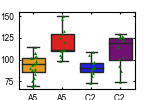

In [9]:
import seaborn as sns

colors = {
    '100CA5': 'orange',
    '200CA5': 'red',
    '100CC2': 'blue',
    '200CC2': 'purple'
}
treatment_order = list(colors.keys())
select=data_harvest[data_harvest['treatment'].isin(colors.keys())]

width = 1.5
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='treatment', y = "dry root [mg]",data=select, ax=ax, color='white', fliersize=0,palette = colors, order=treatment_order)
# Add the individual points
sns.stripplot(x='treatment', y = "dry root [mg]", data=select, ax=ax, color='green', marker='^',size = 2, order=treatment_order)
# ax.set_yscale("log")
ax.set_ylabel("root dry weigth \n ($mg$)")
ax.set_xticklabels(['A5 \n 100C', 'A5 \n 200C','C2 \n 100C', 'C2 \n 200C'])

# Remove x-label
ax.set_xlabel('')
plt.savefig(os.path.join(path_figure,'FigureS4_root_weight.pdf'), transparent=True, bbox_inches='tight')

2024-04-17 08:47:22,551-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


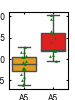

In [17]:
import seaborn as sns

colors = {
    '100CA5': 'orange',
    '200CA5': 'red',
}
treatment_order = list(colors.keys())
select=data_harvest[data_harvest['treatment'].isin(colors.keys())]


width = 0.75
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='treatment', y = "dry root [mg]",data=select, ax=ax, color='white', fliersize=0,palette = colors, order=treatment_order)
# Add the individual points
sns.stripplot(x='treatment', y = "dry root [mg]", data=select, ax=ax, color='green', marker='^',size = 2, order=treatment_order)
# ax.set_yscale("log")
ax.set_ylabel("root dry weigth \n ($mg$)")
ax.set_xticklabels(['A5 \n 100C', 'A5 \n 200C'])

# Remove x-label
ax.set_xlabel('')
ax.set_ylim(65,155)
plt.savefig(os.path.join(path_figure,'FigureS4_root_weight_A5.pdf'), transparent=True, bbox_inches='tight')

2024-04-17 08:47:47,633-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


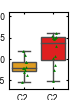

In [18]:
import seaborn as sns

colors = {
    '100CC2': 'orange',
    '200CC2': 'red'
}
treatment_order = list(colors.keys())
select=data_harvest[data_harvest['treatment'].isin(colors.keys())]


width = 0.75
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='treatment', y = "dry root [mg]",data=select, ax=ax, color='white', fliersize=0,palette = colors, order=treatment_order)
# Add the individual points
sns.stripplot(x='treatment', y = "dry root [mg]", data=select, ax=ax, color='green', marker='^',size = 2, order=treatment_order)
# ax.set_yscale("log")
ax.set_ylabel("root dry weigth \n ($mg$)")
ax.set_xticklabels(['C2 \n 100C', 'C2 \n 200C'])

# Remove x-label
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(65,155)

plt.savefig(os.path.join(path_figure,'FigureS4_root_weight_C2.pdf'), transparent=True, bbox_inches='tight')

In [8]:
all_analysis_folders = get_analysis_folders()
plates = [
"822_20231204",
# "866_20231204",
"918_20231110"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info = time_plate_info.replace(-1.0,np.nan)
width = 1.6
height = 1
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,use_saved=False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,use_saved=False)